# Workflows in napari
For using [napari](https://github.com/napari/napari) and [dask](https://dask.dev) together to define and design workflows, we made a small library to make these things more convenient: [napari-workflows](https://github.com/haesleinhuepf/napari-workflows). Goal was to allow the user to setup a workflow by clicking in napari. These workflows are then accessible as object, similar to a dictionary, that can be asked for results of given workflow steps. For example, in the workflow shown below, an input image is blurred using a Gaussian kernel and then thresholded using [Otsu's method](https://ieeexplore.ieee.org/document/4310076) and [scikit-image](https://scikit-image.org).

In [1]:
from napari_workflows import Workflow

from skimage.io import imread
from skimage.filters import threshold_otsu, gaussian
from skimage.measure import label
from pyclesperanto_prototype import imshow

First, we define a workflow and add operations to it. E.g. an operation that takes an image named `"input"` and produces a `"denoised"` image out of it using the `gaussian()` function and `sigma=2` as parameter.

In [2]:
workflow = Workflow()

# define denoising
workflow.set("denoised", gaussian, "input", sigma=2)

We can also add custom function, which is for exmaple necessary to produce a binary image out of an intensity image directly with a single function call.

In [3]:
# define segmentation
def threshold(image):
    return image > threshold_otsu(image)
workflow.set("binarized", threshold, "denoised")

We also apply connected component labeling to the binary image.

In [4]:
workflow.set("labeled", label, "binarized")

# Let's print out the whole workflow
print(str(workflow))

Workflow:
denoised <- (<function gaussian at 0x19b297940>, 'input', 2, None, 'nearest', 0, None, False, 4.0)
binarized <- (<function threshold at 0x19dbd8430>, 'denoised')
labeled <- (<function label at 0x19ba7c820>, 'binarized', None, False)



## Executing workflows
Until here, there were no images involved. We now load an image and store it in the workflow as `"input"`.

In [5]:
workflow.set("input", imread("https://samples.fiji.sc/blobs.png"))

print(str(workflow))

Workflow:
denoised <- (<function gaussian at 0x19b297940>, 'input', 2, None, 'nearest', 0, None, False, 4.0)
binarized <- (<function threshold at 0x19dbd8430>, 'denoised')
labeled <- (<function label at 0x19ba7c820>, 'binarized', None, False)
input <- [[ 40  32  24 ... 216 200 200]
 [ 56  40  24 ... 232 216 216]
 [ 64  48  24 ... 240 232 232]
 ...
 [ 72  80  80 ...  48  48  48]
 [ 80  80  80 ...  48  48  48]
 [ 96  88  80 ...  48  48  48]]



To actually execute computation, we call the `workflow.get()` function that produces a single specified output. Under the hood, it will also execute all intermediate operations that are necessary to come to the final output.

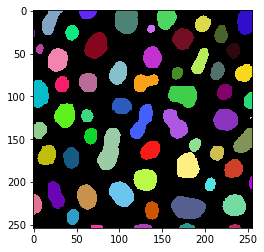

In [6]:
result = workflow.get("labeled")

imshow(result, labels=True)